# Assignment

Yi Zhou

z5548349

## Part 1
### Data Preprocessing
#### step 1: Load the dataset

Use pandas to load the dataset.

In [262]:
import pandas as pd

df = pd.read_csv('dataset.tsv', sep='\t')
pd.set_option('display.width', 180)
pd.set_option('display.max_colwidth', 30)
print(df.head(10))

                     artist_name                     track_name  release_date    genre                         lyrics      topic
0                         loving              the not real lake          2016     rock  awake know go see time cle...       dark
1                        incubus                into the summer          2019     rock  shouldn summer pretty buil...  lifestyle
2                      reignwolf                       hardcore          2016    blues  lose deep catch breath thi...    sadness
3           tedeschi trucks band                         anyhow          2016    blues  run bitter taste take rest...    sadness
4  lukas nelson and promise o...              if i started over          2017    blues  think think different set ...       dark
5                        tia ray                   just my luck          2018     jazz  yeah happen real drink dri...    emotion
6                     rebelution                      trap door          2018   reggae   long lon

#### step 2: Initial Data Cleansing
Drop any duplicates and missing values.

In [263]:
df = df.drop_duplicates()
df = df.dropna()
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1480 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   artist_name   1480 non-null   object
 1   track_name    1480 non-null   object
 2   release_date  1480 non-null   int64 
 3   genre         1480 non-null   object
 4   lyrics        1480 non-null   object
 5   topic         1480 non-null   object
dtypes: int64(1), object(5)
memory usage: 80.9+ KB
None


#### step 3: Text Processing

#### PART 1 QUESTION 1

For this dataset, the regex will remove all kinds of symbols. It's reasonable to keep some symbols like '?' or '!'. So in the following code, I attempt to keep these symbols and try if it will show a different result. The following code will use 'cross_val_predict' from sklearn to train it with cross-validation.

#### PART 1 QUESTION 2

To find the best preprocessing methods, it's good idea to perform a grid search. The parameters will be:

    lower_case: True, False.
    methods to remove stop words: nltk, sklearn or none.
    method to stem the word: porter, lancaster, snowball or wordnetlemm


In [264]:
import re
from itertools import product
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, LancasterStemmer, SnowballStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')


stop_words = set(stopwords.words('english'))

all_matches = set()

# The function to perform the preprocessing
def preprocess_text(text, process_methods):
    if (process_methods['stem'] == 'porter'):
        ps = PorterStemmer()
    elif (process_methods['stem'] == 'lancaster'):
        ps = LancasterStemmer()
    elif (process_methods['stem'] == 'snowball'):
        ps = SnowballStemmer('english')
    else:
        ps = WordNetLemmatizer()

    if (process_methods['lower']):
        text = text.lower()
    # check the regex from the tutorial
    matches = re.findall(r'[^\w\s]', text)
    if len(matches):
        for m in matches:
            all_matches.add(m)
    # modified regex
    if (process_methods['remove_special']):
        text = re.sub(r'[^\w\s\'?!]', '', text)
    tokens = word_tokenize(text)
    if (process_methods['stop_words'] == 'nltk'):
        tokens = [word for word in tokens if word not in stop_words]
    elif (process_methods['stop_words'] == 'sklearn'):
        tokens = [word for word in tokens if word not in ENGLISH_STOP_WORDS]
    if (process_methods['stem'] == 'wordnetlemm'):
        tokens = [ps.lemmatize(word) for word in tokens]
    else:
        tokens = [ps.stem(word) for word in tokens]
    return ' '.join(tokens)

# set of the possible preprocessing methods
preprocessing_combination = {
    'lower': [False, True],
    'remove_special': [True,],
    'stop_words': ['nltk', 'sklearn', 'none'],
    'stem': ['porter', 'lancaster', 'snowball', 'wordnetlemm']
}
keys = list(preprocessing_combination.keys())
values = list(preprocessing_combination.values())
all_combination = [dict(zip(keys, combination)) for combination in product(*values)]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\carl7\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\carl7\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\carl7\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\carl7\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Model Training

Combine all the columns except the 'topic' into one document and perform the preprocessing method to it. Get the result of MNB and calculate the accuracy. Store the best combination of preprocessing for future use.


In [265]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm


max_accuracy = 0
best_comb = None
best_report = None

def getXy(comb, vectorizer):
    X = df['artist_name'] + ' ' + df['track_name'] + ' ' + df['lyrics'] + ' ' + df['release_date'].apply(str) + ' ' + df['genre']
    X = X.apply(preprocess_text, args=(comb,))
    # pd.set_option('display.max_colwidth', 3000)

    # print(X.head())
    X = vectorizer.fit_transform(X)
    y = df['topic']
    return X, y

# Grid Search
for comb in tqdm(all_combination):
    vectorizer = CountVectorizer()
    X, y = getXy(comb, vectorizer)
    mnb = MultinomialNB()
    y_pred = cross_val_predict(mnb, X, y, cv=5)
    cur_accuracy = accuracy_score(y, y_pred)
    if (cur_accuracy > max_accuracy):
        max_accuracy = cur_accuracy
        best_comb = comb
        best_report = classification_report(y, y_pred)


100%|██████████| 24/24 [00:19<00:00,  1.26it/s]


Then we can get the best preprocess combination and the accuracy get from this. It's reasonable to find removing special characters will lead to a better result. But surprisingly, the best result is get by using lancaster stem and not removing any stop words.

In [266]:
print(best_comb)
print(max_accuracy)
print(best_report)

{'lower': False, 'remove_special': True, 'stop_words': 'none', 'stem': 'lancaster'}
0.797972972972973
              precision    recall  f1-score   support

        dark       0.81      0.84      0.83       487
     emotion       0.53      0.32      0.40        79
   lifestyle       0.88      0.69      0.77       202
    personal       0.85      0.82      0.83       341
     sadness       0.75      0.88      0.81       371

    accuracy                           0.80      1480
   macro avg       0.76      0.71      0.73      1480
weighted avg       0.80      0.80      0.79      1480



#### PART 1 QUESTION 3

Accuracy measures the rate of correct predicted samples. However, in an unbalanced dataset, it's possible that it will ignore topics with little samples. Precision calculates how many predicted positive items are correct. Recall calculates how many true positive the model can find. F1 score balances precision and recall. Since this is an unbalanced dataset, if we want to treat the importance of the topics equally, it would be reasonable to choose macro F1-score. In this way, we can get a better result among all topics.

The following code uses the best-performing preprocessing methods get above and compare the metrics of BNB and MNB.

We can see MNB outperforms BNB since it also take the word frequency into consideration. Since some word may appear many times in a certain topic, this is especially helpful for classification.

In [267]:
vectorizer = CountVectorizer()
X, y = getXy(best_comb, vectorizer)
mnb = MultinomialNB()
bnb = BernoulliNB()
y_b_pred = cross_val_predict(bnb, X, y, cv=5)
y_m_pred = cross_val_predict(mnb, X, y, cv=5)
print(classification_report(y, y_m_pred))
print('--------------------------------------')
print(classification_report(y, y_b_pred))


              precision    recall  f1-score   support

        dark       0.81      0.84      0.83       487
     emotion       0.53      0.32      0.40        79
   lifestyle       0.88      0.69      0.77       202
    personal       0.85      0.82      0.83       341
     sadness       0.75      0.88      0.81       371

    accuracy                           0.80      1480
   macro avg       0.76      0.71      0.73      1480
weighted avg       0.80      0.80      0.79      1480

--------------------------------------
              precision    recall  f1-score   support

        dark       0.64      0.74      0.69       487
     emotion       0.00      0.00      0.00        79
   lifestyle       0.24      0.02      0.04       202
    personal       0.68      0.35      0.46       341
     sadness       0.44      0.85      0.58       371

    accuracy                           0.54      1480
   macro avg       0.40      0.39      0.35      1480
weighted avg       0.51      0.54     

#### PART 1 QUESTION 4

The following code tries to find the which number of features perform best for BNB and MNB. As discussed above, the metric here to evaluate the performance will be the macro F1 score. The code limits the max_features for different values and try to find the optimal number.

In [268]:
overall_F1_list = []
b_F1_list = []
m_F1_list = []
max_f1 = 0
best_N = -1
for i in tqdm(range(1, 4001, 20)):
    # limit the feature number
    vectorizer = CountVectorizer(max_features=i)
    X, y = getXy(best_comb, vectorizer)
    mnb = MultinomialNB()
    bnb = BernoulliNB()
    y_b_pred = cross_val_predict(bnb, X, y, cv=5)
    y_m_pred = cross_val_predict(mnb, X, y, cv=5)
    b_F1 = f1_score(y, y_b_pred, average='macro')
    m_F1 = f1_score(y, y_m_pred, average='macro')
    result = b_F1 + m_F1
    if (result > max_f1):
        max_f1 = result
        best_N = i
    overall_F1_list.append(result)
    b_F1_list.append(b_F1)
    m_F1_list.append(m_F1)



100%|██████████| 200/200 [02:55<00:00,  1.14it/s]


Here we can get a visualised result by ploting the F1 score with the x-axis being the number of max features.

The result shows that increasing the number will significately improve the accuracy. Because the model has more features to evaluate. But after passing a certain number, adding more features tends to add more noise, so the performance starts to decrease. The trend is similar for BNB and MNB so we are able to get a value that work well for both of them.

521


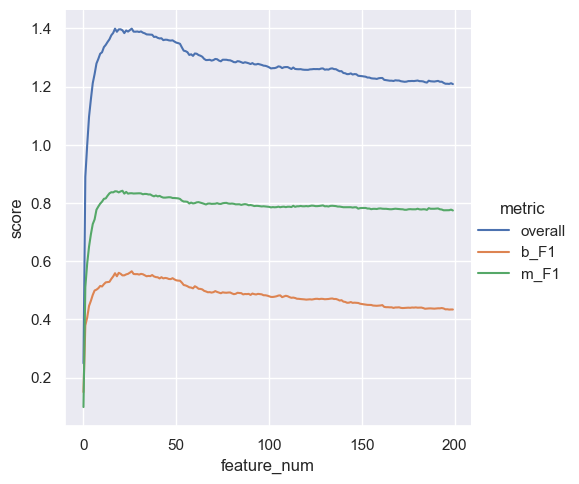

In [269]:
import seaborn as sns

sns.set_theme()
L = len(overall_F1_list)  
f1_df = pd.DataFrame({'feature_num': list(range(L))*3, 'score': overall_F1_list + b_F1_list + m_F1_list, 'metric': ['overall'] * L + ['b_F1'] * L + ['m_F1'] * L})
sns.relplot(data=f1_df, x='feature_num', y='score', hue='metric', kind='line')
print(best_N)

#### PART 1 QUESTION 5

For this part, the method chosen is LinearSVC. It aims to find the boundary between classes and it's suitable for sparse dataset classification. In our case, the songs are classified by it's lyrics and title and so on, making the method particularly suitable for this problem.

There are some hyperparameters for the function from sklearn.

The first one is 'C', which decides the regularization strength. Small C may cause underfitting and low accuracy, but may also help the model ignore more noise. A large C value applies less regularization but may make the model become overfitting.

The second parameter is 'max_iter', which decides how many number of iterations to train.

The third is 'class_weight', which may be useful when dealing with an unbalanced dataset.

To find the best hyperparameter settings, it's best to perform a Grid Search as the code below.  And as mentioned above, the macro F1 score will be the metric to decide the model's performance.

In [270]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

vectorizer = CountVectorizer(max_features=best_N)

param_combination = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'max_iter': [1000, 3000, 7000, 10000],
    'class_weight': ['balanced', None],
}

# get all combinations of the param settings
keys = list(param_combination.keys())
values = list(param_combination.values())
all_param_combination = [dict(zip(keys, combination)) for combination in product(*values)]

best_score = -1
best_param_comb = None
best_param_report = None
for param_comb in tqdm(all_param_combination):
    svc = LinearSVC(**param_comb)
    X, y = getXy(best_comb, vectorizer)
    y_svc_pred = cross_val_predict(svc, X, y, cv=5)
    cur_score = f1_score(y, y_svc_pred, average='macro')
    if (cur_score > best_score):
        best_score = cur_score
        best_param_comb = param_comb
        best_param_report = classification_report(y, y_svc_pred)


100%|██████████| 48/48 [01:11<00:00,  1.49s/it]


Here we get the hyperparameter settings for best result. And the result shows an accuracy of 87% and macro F1 of 85%, which is better than BNB or MNB. It's worth noting that the best result comes from the one without balanced class weight. This could be because after applying a small 'C', the impact of the class_weight is smaller.

In [271]:
print(best_param_comb)
print(best_param_report)

{'C': 0.001, 'max_iter': 1000, 'class_weight': None}
              precision    recall  f1-score   support

        dark       0.81      0.93      0.87       487
     emotion       0.93      0.67      0.78        79
   lifestyle       0.88      0.79      0.83       202
    personal       0.92      0.87      0.89       341
     sadness       0.91      0.88      0.90       371

    accuracy                           0.87      1480
   macro avg       0.89      0.83      0.85      1480
weighted avg       0.88      0.87      0.87      1480



### PART 2

#### PART 2 QUESTION 1

##### Data Processing

First, the training and testing dataset are split from the dataset. Then a TF-IDF vector is built for each topic based on the content for this topic in the training dataset. The result is stored in a dictionary for future use.

In [272]:
df['content'] = df['artist_name'] + ' ' + df['track_name'] + ' ' + df['lyrics'] + ' ' + df['release_date'].apply(str) + ' ' + df['genre']
train_dataset = df[:750]
test_dataset = df[750:1000]['content']
pd.set_option('display.max_colwidth', 30)
train_topic_content = {}
topic_list = ['dark', 'lifestyle', 'personal', 'sadness', 'emotion']
for topic in topic_list:
    train_topic_content[topic] = train_dataset[train_dataset['topic'] == topic]['content']
train_tfidf_vec_list = {}
test_tfidf_vec_list = {}
# build a TF-IDF vector for each topic, this is not used for classification, but for recommender algorithm
for topic in topic_list:
    train_tfidf_vec_list[topic] = {}
    tem_vectorizer = TfidfVectorizer()
    train_tfidf_vec_list[topic]['matrix'] = tem_vectorizer.fit_transform(train_topic_content[topic])
    train_tfidf_vec_list[topic]['vectorizer'] = tem_vectorizer

##### Train the classification model

Using the best method and settings from PART 1, we are able to train a model based on the training dataset.

In [273]:
vectorizer = CountVectorizer(max_features=best_N)
X, y = getXy(best_comb, vectorizer)
train_X = X[:750]
train_y = list(y[:750])
train_topic_df = {}
for topic in topic_list:
    train_topic_df[topic] = []
for i in range(750):
    train_topic_df[train_y[i]].append(i)
for topic in topic_list:
    train_topic_df[topic] = train_X[train_topic_df[topic]]
svc = LinearSVC(**best_param_comb)
svc.fit(train_X, train_y)
pred_y = svc.predict(train_X)
print(classification_report(train_y, pred_y))

              precision    recall  f1-score   support

        dark       0.92      0.98      0.95       246
     emotion       1.00      0.88      0.94        42
   lifestyle       0.96      0.92      0.94        92
    personal       0.97      0.94      0.96       187
     sadness       0.98      0.97      0.98       183

    accuracy                           0.95       750
   macro avg       0.97      0.94      0.95       750
weighted avg       0.96      0.95      0.95       750



Since we don't have any actual user, we can only assume a user likes a song if the song contains any keywords the user likes.

In [274]:
def is_interested(keywords, content):
    for keyword in keywords:
        if (keyword in content):
            return True
    return False

In [ ]:
# load and build the user keywords dictionary
def load_user(filename):

    user = pd.read_csv(filename, sep='\t')
    user_topic_keywords = {}
    for row in user.values:
        user_topic_keywords[row[0]] = row[1].split(', ')
    return user_topic_keywords

We will test which songs in the training set the user likes. Then we are able to build a user profile, which is a document containing all the songs the user likes. By using the vectorizer build for the specific topic, we are able to get a metrix for the user.

In [276]:
def get_user_profile(filename):
    user = load_user(filename)
    # print(user1)
    user_profile = {}
    for topic in topic_list:
        user_profile[topic] = []
    # add a song to the user's profile if its predicted topic matches the actual topic
    # and if the song contians keywords the user likes
    for topic, topic_df in train_topic_df.items():
        L = len(train_topic_content[topic])
        y_pred = svc.predict(topic_df)
        for i in range(L):
            cur_content = train_dataset.loc[i]['content']
            if (y_pred[i] == topic and user.get(topic) and is_interested(user[topic], cur_content)):
                user_profile[topic].append(cur_content)
    # store the number of songs the user like for each topic, we want to know how much a user likes a topic
    # store the matrix get from the vectorizer build based on the whole topic document, for similarity calculation
    for topic in topic_list:
        liked_num = len(user_profile[topic])
        user_profile[topic] = {'doc': ' '.join(user_profile[topic]), 'len': liked_num, 'key_words': user.get(topic) or []}
        user_profile[topic]['vector'] = train_tfidf_vec_list[topic]['vectorizer'].transform([user_profile[topic]['doc']])
    return user_profile


##### Get top 20 words

For each topic, we can then extract the feature from the user metrix and get the feature name. It's worth noting that the document for a certain topic can be empty. In this case, the user does not like any song from that topic and the value in the matrix will be 0. We won't get any words for these kinds of topic.

As the results shown below, we can definitely see the relavance between these words and the topic. For example, the 'dark' topic contains words like 'blood' and 'pain'. 

For the same topic, we can also see the top words being different. Meaning we did manage to build and extract features for a certain user based on thier interests.

In [277]:
def show_topM(user_profile, M=20):
    for topic, content in user_profile.items():
        # extract the feature from the TF-IDF matrix
        feature_names = train_tfidf_vec_list[topic]['vectorizer'].get_feature_names_out()
        user_vector = content['vector']
        scores = user_vector.toarray()[0]
        score_index = np.argsort(scores)
        L = len(score_index) - 1
        res = []
        while (len(res) != 20):
            if (scores[score_index[L]] == 0):
                break
            res.append(feature_names[score_index[L]])
            L -= 1
        print(topic)
        print(res)

user1_profile = get_user_profile('user1.tsv')
print('top 20 words for user1:')
show_topM(user1_profile)
print()
print('top 20 words for user2:')
user2_profile = get_user_profile('user2.tsv')
show_topM(user2_profile)


top 20 words for user1:
dark
['fight', 'like', 'change', 'yeah', 'good', 'know', 'blood', 'hurt', 'fall', 'come', 'pain', 'heart', 'baby', 'woah', 'lanky', 'dilly', 'wall', 'life', 'gonna', 'mind']
lifestyle
['feel', 'promise', 'world', 'good', 'fall', 'telephone', 'south', 'know', 'wanna', 'steal', 'gonna', 'like', 'away', 'stay', 'tonight', 'right', 'heart', 'wait', 'face', 'kiss']
personal
['strangers', 'life', 'wanna', 'night', 'away', 'like', 'heart', 'hurt', 'promise', 'look', 'know', 'come', 'head', 'break', 'walk', 'song', 'learn', 'live', 'feel', 'dream']
sadness
['blood', 'spoil', 'cry', 'night', 'sister', 'people', 'steal', 'yeah', 'woman', 'good', 'reason', 'come', 'control', 'like', 'regret', 'alive', 'go', 'hold', 'say', 'time']
emotion
['promise', 'night', 'feel', 'good', 'fall', 'grow', 'luck', 'know', 'yeah', 'life', 'anytime', 'understand', 'hand', 'lose', 'walk', 'like', 'doin', 'away', 'leave', 'open']

top 20 words for user2:
dark
[]
lifestyle
[]
personal
[]
sadnes

##### Test a third user

Here we build a profile for another user. This user likes keywords that are more general in the database. So although we can still see how the top 20 words relavant to the topic, we also can see more general words appear in this list. This is also reasonalbe since the user could like a lot of the songs in the list.

In [ ]:
print('top 20 words for user3:')
# content for user3.tsv, please create this file if you want to run this block.
'''
topic	keywords
dark	scream, devil, black, burn, crawl
sadness	lonely, lose, heart, madness, worst
personal	reason, kiss, tomorrow, forever, grow
'''
user3_profile = get_user_profile('user3.tsv')
show_topM(user3_profile)

top 20 words for user3:
dark
['blood', 'gonna', 'black', 'know', 'lanky', 'dilly', 'burn', 'night', 'like', 'south', 'life', 'devil', 'yeah', 'people', 'right', 'wing', 'dirty', 'come', 'time', 'stay']
lifestyle
[]
personal
['blood', 'gonna', 'wanna', 'kiss', 'fall', 'away', 'promise', 'steal', 'call', 'night', 'like', 'know', 'woah', 'live', 'hand', 'grow', 'luck', 'baby', 'fight', 'lose']
sadness
['wanna', 'know', 'blood', 'like', 'strangers', 'life', 'lose', 'live', 'right', 'heart', 'hand', 'night', 'feel', 'baby', 'good', 'break', 'gonna', 'promise', 'spoil', 'people']
emotion
[]


#### PART 2 QUESTION 2

##### Classify the test set

The first step is to classify the topic of the test set. The classifier is the one trained before. Then we can generate a TF-IDF vector for each song based on the predicted topic. This TF-IDF matrix will be used to calculate the similarity between the songs and the user profile. 

In [279]:
test_X = X[750:1000]
pred_topic = svc.predict(test_X)
test_topic_content = {}
test_tfidf_vec_list = {}
for topic in topic_list:
    test_topic_content[topic] = []
# separate the test set based on the predicted topic
for ind, topic in enumerate(pred_topic):
    test_topic_content[topic].append((ind))
# generate a TF-IDF vector for each song
for topic in topic_list:
    arr = test_topic_content[topic]
    test_topic_content[topic] = test_dataset.iloc[arr]
    test_tfidf_vec_list[topic] = train_tfidf_vec_list[topic]['vectorizer'].transform(test_topic_content[topic])
print(test_topic_content)

{'dark': 752     soccer mommy your dog want...
753     the score revolution wolve...
754     l'indécis sunrise drive br...
757     adelitas way notorious not...
762     des rocs dead ringer hold ...
                    ...              
998     godsmack under your scars ...
999     white denim just dropped i...
1000    meshuggah monstrocity skyl...
1001    thank you scientist blue a...
1005    bts not today 방탄소년단의 today...
Name: content, Length: 89, dtype: object, 'lifestyle': 755     gary hoey boxcar blues box...
775     marcus miller 7-t's right ...
785     gary clark jr. gotta get i...
795     wallows it's only right wa...
806     diana krall moonglow moong...
810     notd so close think lie dr...
845     jada kingdom wasteman time...
857     magic! kiss me kiss darlin...
858     glass animals mama's gun s...
864     digitalluc rethymno hearts...
869     fruit bats absolute loser ...
870     fumez the engineer pull up...
876     brothers osborne 21 summer...
883     jamie berry ligh

##### Get recommendation

We decides to recommend a total number of 20 songs to a user. The interface would be a section called 'Guess you like' and showing 10 songs per page. This gives the user a certain amount of freedom to choose. However, considering the number of songs, we would want to place the song which the user might like at the front of the list.

We will test 4 different type of similarity algorithm and choose the best one from them. Some algorithms consider the actual position of the vector and compute the similarity, others simply calculate the similarity between two sets.

Based on the algorithm, we will rank the songs in each topic in Week 4 for evaluation.

In [280]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import ndcg_score, jaccard_score, pairwise_distances

N = 20

def get_rec_list(user_profile, sim_alg, M=0):
    for topic in topic_list:
        user_vector = user_profile[topic]['vector']
        # if using top M words from the user profile instead of all
        if (M != 0):
            # get the top M frequent words based on the vector
            top_M = np.argsort(user_profile[topic]['vector'].toarray().flatten())
            L = len(top_M)
            lil = user_vector.tolil()
            for i in range(L - M):
                lil[0,top_M[i]] = 0
            user_vector = lil.tocsr()
        if (sim_alg == 'cosine'):
            score = cosine_similarity(test_tfidf_vec_list[topic], user_vector)
            score = score.flatten()
        elif (sim_alg == 'euclidean'):
            dis = euclidean_distances(test_tfidf_vec_list[topic], user_vector)
            score = np.exp(-dis).flatten()
        elif (sim_alg == 'jaccard'):
            test_set = (test_tfidf_vec_list[topic] > 0)
            user_set = (user_vector > 0).toarray()[0]
            score = [jaccard_score(test_song.toarray()[0], user_set) for test_song in test_set]
        elif (sim_alg == 'sorensen'):
            test_set = (test_tfidf_vec_list[topic] > 0).toarray()
            user_set = (user_vector > 0).toarray()
            sorensen_match = 1 - pairwise_distances(test_set, user_set, metric='dice')
            score = sorensen_match.flatten()
        # print(score)
        top_songs = np.argsort(score)[::-1]
        user_profile[topic]['rec_list'] = top_songs
        user_profile[topic]['rec_scores'] = np.sort(score)[::-1]


Considering the user might enjoys a lot songs from one topic and only likes a few from other topics, we wouldn't want to recommend songs from every topic evenly. Instead, if the user likes a lot songs for one topic, the system will recommend more songs for this topic. So the 20 songs will be weighted-selected from 5 topics.

As for the evalutation, obviousely we care about the precision@N, which tells how accurate our recommendation is. Recall@N is not choosed because the number N here is 20, which is a small number comparing to the whole dataset, so the metric will always be small and lacks helpful information.

Another metric we choose is nDCG, which can also tell if the order of the list is correct.

As the result shows, we get an accurate recommendation for user 1 and user 3. The result for user 2 is pretty low. This could be because the user has a special taste and only likes a small group of songs. 

As for the difference among the similarity algorithms, the nDCG metrics for these 4 algorithms are pretty close. As for the precision@N, we can see jaccard and sorensen performs a little bit better for user 1 and 2. If our system aims to provide accurate recommendation for all users, these two algorithms would be prefered. However, if we only care more about general user(e.g. user 3)'s interests and hope others can grow to like more songs, cosine similarity or euclidean similarity can be choosed.

In [281]:
# calculate how many songs to return from each topic
# based on how many songs the user already likes in that topic
def get_weighted_recommend_list(user_profile, N):
    liked_num = []
    for topic in topic_list:
        liked_num.append(user_profile[topic]['len'])
    liked_num = liked_num / np.sum(liked_num) * N
    liked_num = np.round(liked_num)
    while (int(np.sum(liked_num)) != N):
        ind = np.argmax(liked_num)
        liked_num[ind] = liked_num[ind] + 1 if np.sum(liked_num) < N else liked_num[ind] - 1
    ans = []
    score_list = []
    for ind, topic in enumerate(topic_list):
        cur_topic_list = user_profile[topic]['rec_list']
        cur_topic_scores = user_profile[topic]['rec_scores']
        r = int(liked_num[ind])
        score_list.append(cur_topic_scores[:r])
        ans.append(cur_topic_list[:r])
    return ans, score_list

# after getting the list, check if the songs contains the keywords the user likes
# returns precision@N and nDCG
def evaluate_rec(user_profile):
    rec_list, score_list = get_weighted_recommend_list(user_profile, N)
    
    pred_num = 0
    true_list = []
    for ind, topic in enumerate(topic_list):
        for song_ind in rec_list[ind]:
            cur_song = test_topic_content[topic].iloc[song_ind]
            if (is_interested(user_profile[topic]['key_words'], cur_song)):
                true_list.append(1)
            else:
                true_list.append(0)
    score_list = np.concatenate(score_list)
    p_N = np.sum(true_list) / N
    ndcg_s = ndcg_score([true_list], [score_list])
    return p_N, ndcg_s



for sim_alg in ['cosine', 'euclidean', 'jaccard', 'sorensen']:
    print('-----------------------------')
    print(sim_alg)
    get_rec_list(user1_profile, sim_alg)
    print(evaluate_rec(user1_profile))
    get_rec_list(user2_profile, sim_alg)
    print(evaluate_rec(user2_profile))
    get_rec_list(user3_profile, sim_alg)
    print(evaluate_rec(user3_profile))

# evaluate_rec(user2_profile)
# evaluate_rec(user3_profile)

-----------------------------
cosine
(0.85, 0.9526942787016631)
(0.1, 0.4140749156809286)
(0.75, 0.9545735931191556)
-----------------------------
euclidean
(0.85, 0.9526942787016631)
(0.1, 0.4140749156809286)
(0.75, 0.9545735931191556)
-----------------------------
jaccard
(0.85, 0.9999999999999999)
(0.25, 0.5898018459057794)
(0.5, 0.8665201629951848)
-----------------------------
sorensen
(0.85, 0.9999999999999999)
(0.25, 0.5898018459057794)
(0.5, 0.8665201629951848)


Then consider using top M words from the user profile instead of using the whole document. As the result shows below, it's won't provide a better result. This could be because TF-IDF already take consider of the frequency among the whole document. Common words will already have a small value so removing them won't help improve the accuracy.

In [282]:
user1_topM = []
user2_topM = []
user3_topM = []
for i in range(1, 60, 3):
    get_rec_list(user1_profile, 'jaccard', i)
    p, _ = evaluate_rec(user1_profile)
    user1_topM.append(p)
    get_rec_list(user2_profile, 'jaccard', i)
    p, _ = evaluate_rec(user2_profile)
    user2_topM.append(p)
    get_rec_list(user3_profile, 'jaccard', i)
    p, _ = evaluate_rec(user3_profile)
    user3_topM.append(p)




521


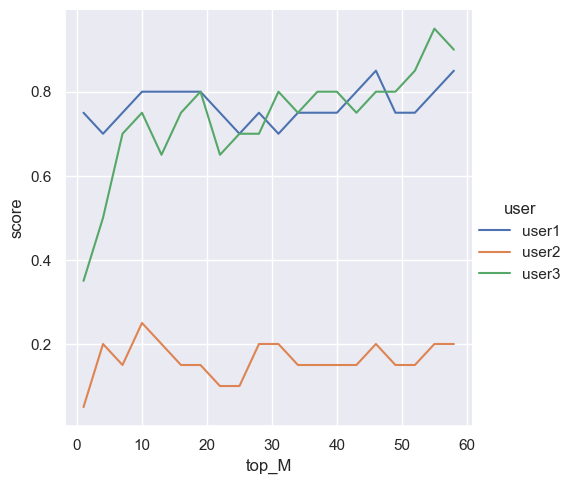

In [283]:
L = len(user1_topM)  
topM_df = pd.DataFrame({'top_M': list(range(1, 60, 3))*3, 'score': user1_topM + user2_topM + user3_topM, 'user': ['user1'] * L + ['user2'] * L + ['user3'] * L})
sns.relplot(data=topM_df, x='top_M', y='score', hue='user', kind='line')
print(best_N)

### PART 3

For the first three weeks, the system will just randomly choose 20 songs for the user to choose. Please note that random songs will be generated for each run. So the index may not match those which the user pick we asked for the users feedback a while ago.

In [284]:
import random
pd.set_option('display.max_colwidth', 40)
def get_rand_songs(week):
    cur_week = df[(week-1)*250:week*250]
    rand_20 = random.sample(range(250), 20)
    # print(rand_20)
    print(cur_week.iloc[sorted(rand_20)])

get_rand_songs(1)

                              artist_name                     track_name  release_date    genre                                   lyrics      topic  \
4    lukas nelson and promise of the real              if i started over          2017    blues  think think different set apart sobe...       dark   
9                          eli young band                     never land          2017  country  word yeah wreck roll lips high good ...    sadness   
10                                   klim                     ninetofive          2018     jazz  nice place think sky separate nice s...   personal   
14                                 khalid                         winter          2017      pop  lose heart nighttime leave cold leav...   personal   
30                                popcaan                    traumatized          2019   reggae  screamin lorax gang deffame californ...       dark   
43                          riley richard                         l.i.t.          2018     jaz

In [285]:
get_rand_songs(2)

                           artist_name                              track_name  release_date    genre                                   lyrics      topic  \
263  nahko and medicine for the people                              directions          2016   reggae  north east south grandfather call ne...  lifestyle   
264                        talib kweli                       ny weather report          2018  hip hop  come yeah like opportunity thank eve...       dark   
276                          audio two                           make it funky          2017  hip hop  sameoldshawn kind music listen time ...  lifestyle   
286                        high valley                               i be u be          2016  country  soldier line courage heart fight out...   personal   
295                             pepper                                   bones          2016   reggae  say bonecrunching mayhem funk caroon...  lifestyle   
319                       the movement                    

In [286]:
get_rand_songs(3)

                              artist_name                       track_name  release_date    genre                                   lyrics      topic  \
524                       michael lington                    break the ice          2018     jazz  haile selassie chapel power trinity ...   personal   
541                                 kbong                       good lovin          2017   reggae  good good good lovin gimme good good...    emotion   
548                         joe bonamassa  some other day, some other time          2016    blues  time wanna hold time wanna kiss baby...  lifestyle   
584                         chris cornell             nothing compares 2 u          2018     rock  seven hours days take away night sle...    sadness   
590                     fantastic negrito                     about a bird          2017    blues  window watch sell hop fall bush hand...       dark   
591                           eric church                     hippie radio        

Below shows the songs picked by the user. Then we are able to use the same method from PART 2 to generate a recommendation list from week4.

In [ ]:
# song index picked by the user
selected_songs = [0, 19, 119, 151, 177, 196, 287, 296, 334, 368, 478, 538, 542, 553, 720, 743]
pd.set_option('display.max_colwidth', 150)
# get the content of those songs and get the predicted topic
user_selected = real_user_df = df.loc[selected_songs]['content']
real_user_profile = {}
real_user_df = real_user_df.apply(preprocess_text, args=(best_comb,))
real_user_df = vectorizer.transform(real_user_df)
pred_topic = svc.predict(real_user_df)
# build a user profile based on the predicted topic
# use the same vectorizer build from week1 to 3.
for topic in topic_list:
    real_user_profile[topic] = []
for ind, topic in enumerate(pred_topic):
    real_user_profile[topic].append(user_selected.iloc[ind])
for topic in topic_list:
    liked_num = len(real_user_profile[topic])
    real_user_profile[topic] = {'doc': ' '.join(real_user_profile[topic]), 'len': liked_num, 'key_words': []}
    real_user_profile[topic]['vector'] = train_tfidf_vec_list[topic]['vectorizer'].transform([real_user_profile[topic]['doc']])
# use the same method to get a recommend list and order it based on the score
get_rec_list(real_user_profile, 'jaccard')
rec_list, score_list = get_weighted_recommend_list(real_user_profile, N)
score_list = np.concatenate(score_list)
# the list is not ordered, so we need to get the correct order based on the score
display_order = np.argsort(score_list)[::-1]
test_set = df[750:1000]
rec_song_list = []
for ind, topic in enumerate(topic_list):
    for song_ind in rec_list[ind]:
        cur_song = test_set[test_set['topic'] == topic].iloc[song_ind]
        rec_song_list.append(cur_song)
for order in display_order:
    print(order)
    print(rec_song_list[order])


9
artist_name                                                                                                                                                prettymuch
track_name                                                                                                                                                  open arms
release_date                                                                                                                                                     2017
genre                                                                                                                                                             pop
lyrics          prettymuch try baby start face fact whoa cuff know catch slippin need wanna touch turn away whoa girl tear apart help waitin open arm ready know h...
topic                                                                                                                                                       lifestyle
co

We asked if the user liked these songs and was able to get their feed back. Below shows the precision@N and nDCG value. We are able to get a 50% precision and the nDCG is acceptable.

#### Discussion

The precision@N is 50%. This is lower than the 0.8 from user1. This could be because since the actual user does not pick their interested songs base on a set of keywords, instead, they may put more weight on the title or the artist name. The algorithm treat all the information equally, so may lead to a lower accuracy.

##### User Comment

I would say the list is pretty accurate. I didn't see the label of the song, but I intended to pick songs that are somewhat sad and negative. So the result is pretty accurate. But to be honest, I kind of lost patient after the 10th song or so. So for the rest of the list, I decided that if I don't like the title or the first 10 words of the lyrics, I'll pass it. 20 songs are a lot if I have to check them one by one. But suppose they are listed in a section, I suppose it's fine for me to just check them randomly.

In [299]:
real_liked_list = [0,1,1,0,0,1,0,1,0,0,1,1,1,0,0,1,1,1,0,0]
p_N = np.sum(real_liked_list) / N
ndcg_s = ndcg_score([real_liked_list], [score_list])
print(p_N)
print(ndcg_s)

0.5
0.7650531241737677
